### Generate Images - VAE

In [89]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image

from models import VAE

In [90]:
device = 'cuda:0'
checkpoint = torch.load('result/VAE_3/best_model.pt')
number_of_gen = 100

In [91]:
model = VAE('ELU')
model.load_state_dict(checkpoint)
model.to(device)

VAE(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (4): ELU(alpha=1.0)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (6): ELU(alpha=1.0)
      (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
      (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (4): ELU(alpha=1.0)
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (6): ELU(alpha=1.0)
      (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ELU(alpha=1.0)
  

In [99]:
gen_imgs = model.generate_sample(torch.randn(number_of_gen, 512, device='cuda'))

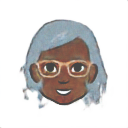

In [100]:
to_pil_image(gen_imgs[0])

In [9]:
for index in range(number_of_gen):
    save_image(gen_imgs[index, :, :], f'gen_data/{index}.png', normalize=True)

### Generate Images - GAN

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image

from models import Discriminator, Generator

In [ ]:
device = 'cuda:0'
checkpoint = torch.load('result/GAN_1/119.pt')
number_of_gen = 100

In [ ]:
generator = Generator()
generator.load_state_dict(checkpoint)
generator.to(device)

In [ ]:
z = torch.randn((number_of_gen, 512), device=device)
gen_imgs = generator(z)

In [ ]:
for index in range(100):
    save_image(gen_imgs[index, :, :], f'gen_data/{index}.png', normalize=True)

### Detect AI generated image

In [3]:
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

from data import DataSet
from models import AutoEncoder

In [3]:
dataset = DataSet(base_path='../data/cartoonset100k')

In [26]:
train_index, test_index = train_test_split(range(len(dataset)), test_size=0.3, random_state=0) # fix random state
test_dataset = Subset(dataset, test_index)
print(len(test_dataset))
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4, #pin_memory=True
)

30000


In [46]:
gan_dataset = DataSet(base_path='./gan_gen', is_for_anomaly=True)
vae_dataset = DataSet(base_path='./vae_gen', is_for_anomaly=True)
print(len(gan_dataset))
print(len(vae_dataset))

100
100


In [47]:
gan_loader = DataLoader(
    gan_dataset, batch_size=1, shuffle=False, num_workers=4, #pin_memory=True
)
vae_loader = DataLoader(
    vae_dataset, batch_size=1, shuffle=False, num_workers=4, #pin_memory=True
)

In [18]:
model = AutoEncoder('ELU')
checkpoint = torch.load('result/AE_6/best_model.pt')
model.load_state_dict(checkpoint)
model.cuda()

AutoEncoder(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (4): ELU(alpha=1.0)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (6): ELU(alpha=1.0)
      (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
      (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (4): ELU(alpha=1.0)
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (6): ELU(alpha=1.0)
      (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ELU(alpha

In [29]:
def collect_losses(model, dataloader):
    model.eval()
    loss_fn = torch.nn.MSELoss()
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.cuda()
            output = model(batch)            
            loss = loss_fn(output, batch)
            losses.append(loss.cpu().item())
    return losses

In [84]:
vae_loss = collect_losses(model, vae_loader)
gan_loss = collect_losses(model, gan_loader)
# test_loss = collect_losses(model, test_loader)

In [68]:
test_loss_mean = np.mean(test_loss)
test_max = max(test_loss)
test_min = min(test_loss)
print(test_loss_mean)
print(test_max)

0.00020177162137867223
0.0026866020634770393


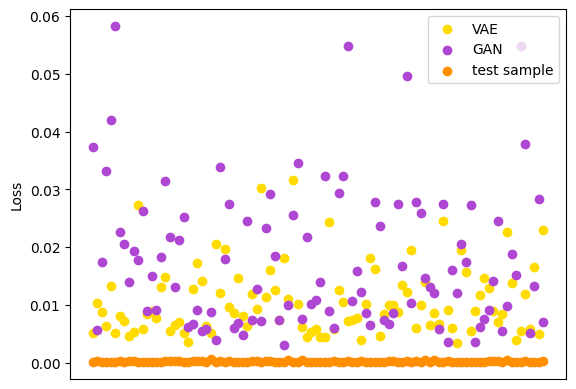

In [86]:
plt.scatter(range(100), vae_loss, color='#FFDB00', label='VAE')
plt.scatter(range(100), gan_loss, color='#AF47D2', label='GAN')
plt.scatter(range(100), test_loss[:100], color='#FF8F00', label='test sample')
plt.ylabel('Loss')
plt.xticks([])
plt.legend()
plt.show()

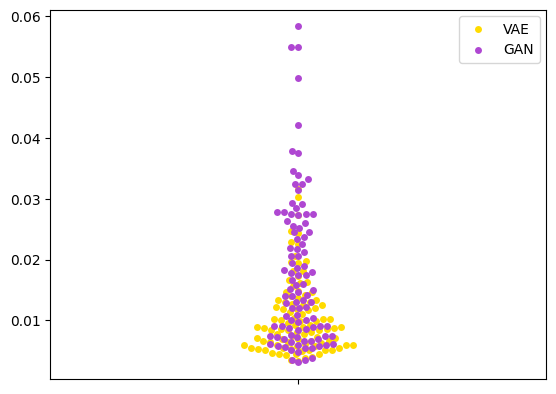

In [87]:
sns.swarmplot(vae_loss, label='VAE', color='#FFDB00')
sns.swarmplot(gan_loss, label='GAN', color='#AF47D2')
plt.legend()
plt.show()

In [91]:
type(vae_loss[0])

float

In [88]:
min(min(vae_loss), min(gan_loss))

0.003131949109956622

In [92]:
max(test_loss)

0.0026866020634770393